<a id="3"></a> <br>
### Logistic Regression
- Linear regression is not good at classification.
- We use logistic regression for classification.
- linear regression + logistic function(softmax) = logistic regression
- Check my deep learning tutorial. There is detailed explanation of logistic regression. 
    - https://www.kaggle.com/kanncaa1/deep-learning-tutorial-for-beginners
- **Steps of Logistic Regression**
    1. Import Libraries
    1. Prepare Dataset
        - We use MNIST dataset.
        - There are 28*28 images and 10 labels from 0 to 9
        - Data is not normalized so we divide each image to 255 that is basic normalization for images.
        - In order to split data, we use train_test_split method from sklearn library
        - Size of train data is 80% and size of test data is 20%.
        - Create feature and target tensors. At the next parts we create variable from these tensors. As you remember we need to define variable for accumulation of gradients.
        - batch_size = batch size means is that for example we have data and it includes 1000 sample. We can train 1000 sample in a same time or we can divide it 10 groups which include 100 sample and train 10 groups in order. Batch size is the group size. For example, I choose batch_size = 100, that means in order to train all data only once we have 336 groups. We train each groups(336) that have batch_size(quota) 100. Finally we train 33600 sample one time.
        - epoch: 1 epoch means training all samples one time.
        - In our example: we have 33600 sample to train and we decide our batch_size is 100. Also we decide epoch is 29(accuracy achieves almost highest value when epoch is 29). Data is trained 29 times. Question is that how many iteration do I need? Lets calculate: 
            - training data 1 times = training 33600 sample (because data includes 33600 sample) 
            - But we split our data 336 groups(group_size = batch_size = 100) our data 
            - Therefore, 1 epoch(training data only once) takes 336 iteration
            - We have 29 epoch, so total iterarion is 9744(that is almost 10000 which I used)
        - TensorDataset(): Data set wrapping tensors. Each sample is retrieved by indexing tensors along the first dimension.
        - DataLoader(): It combines dataset and sample. It also provides multi process iterators over the dataset.
        - Visualize one of the images in dataset
    1. Create Logistic Regression Model
        - Same with linear regression.
        - However as you expect, there should be logistic function in model right?
        - In pytorch, logistic function is in the loss function where we will use at next parts.
    1. Instantiate Model
        - input_dim = 28*28 # size of image px*px
        - output_dim = 10  # labels 0,1,2,3,4,5,6,7,8,9
        - create model
    1. Instantiate Loss 
        - Cross entropy loss
        - It calculates loss that is not surprise :)
        - It also has softmax(logistic function) in it.
    1. Instantiate Optimizer 
        - SGD Optimizer
    1. Traning the Model
    1. Prediction
- As a result, as you can see from plot, while loss decreasing, accuracy(almost 85%) is increasing and our model is learning(training).    

In [13]:
# Import Libraries
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split

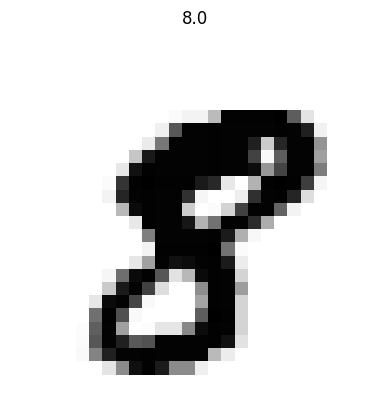

In [27]:
# Prepare Dataset
# load data
train = pd.read_csv(r"input/train.csv",dtype = np.float32)

# split data into features(pixels) and labels(numbers from 0 to 9)
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255 # normalization

# train test split. Size of train data is 80% and size of test data is 20%. 
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42) 

# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

# batch_size, epoch and iteration
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

# visualize one of the images in data set
plt.imshow(features_numpy[10].reshape(28,28),cmap='Greys')
plt.axis("off")
plt.title(str(targets_numpy[10]))
plt.savefig('graph.png')
plt.show()

In [15]:
# Create Logistic Regression Model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        # Linear part
        self.linear = nn.Linear(input_dim, output_dim)
        # There should be logistic function right?
        # However logistic function in pytorch is in loss function
        # So actually we do not forget to put it, it is only at next parts
    
    def forward(self, x):
        out = self.linear(x)
        return out

# Instantiate Model Class
input_dim = 28*28 # size of image px*px
output_dim = 10  # labels 0,1,2,3,4,5,6,7,8,9

# create logistic regression model
model = LogisticRegressionModel(input_dim, output_dim)

# Cross Entropy Loss  
error = nn.CrossEntropyLoss()

# SGD Optimizer 
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [16]:
# Traning the Model
count = 0
loss_list = []
iteration_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        # Define variables
        train = Variable(images.view(-1, 28*28))
        labels = Variable(labels)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        
        # Calculate gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
        # Prediction
        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Predict test dataset
            for images, labels in test_loader: 
                test = Variable(images.view(-1, 28*28))
                
                # Forward propagation
                outputs = model(test)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)
                
                # Total correct predictions
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {}%'.format(count, loss.data, accuracy))

Iteration: 500  Loss: 1.8024988174438477  Accuracy: 66.73809814453125%
Iteration: 1000  Loss: 1.6046000719070435  Accuracy: 75.01190185546875%
Iteration: 1500  Loss: 1.2949936389923096  Accuracy: 78.3452377319336%
Iteration: 2000  Loss: 1.1993030309677124  Accuracy: 80.05952453613281%
Iteration: 2500  Loss: 1.037734866142273  Accuracy: 81.32142639160156%
Iteration: 3000  Loss: 0.9348052144050598  Accuracy: 82.19047546386719%
Iteration: 3500  Loss: 0.8967711925506592  Accuracy: 82.92857360839844%
Iteration: 4000  Loss: 0.7540315985679626  Accuracy: 83.54762268066406%
Iteration: 4500  Loss: 0.9681786298751831  Accuracy: 83.91666412353516%
Iteration: 5000  Loss: 0.7934004068374634  Accuracy: 84.23809814453125%
Iteration: 5500  Loss: 0.7483624219894409  Accuracy: 84.5952377319336%
Iteration: 6000  Loss: 0.8692571520805359  Accuracy: 84.89286041259766%
Iteration: 6500  Loss: 0.6538797616958618  Accuracy: 85.05952453613281%
Iteration: 7000  Loss: 0.7074441313743591  Accuracy: 85.309524536132

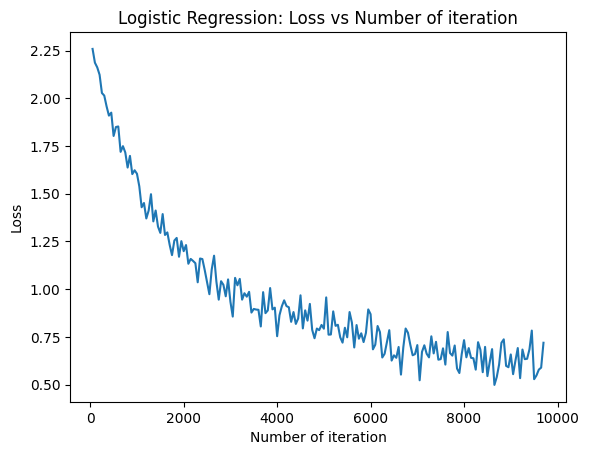

In [17]:
# visualization
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Logistic Regression: Loss vs Number of iteration")
plt.show()